In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'top_model_weights_path.h5'

In [3]:
epochs = 50
batch_size = 16
split=0.9

In [4]:
X_train=np.load('X_train_rotate.npy')
target_train=np.load('target_train.npy')
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, train_size=split)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=(75,75,3))
print('Model loaded.')

Model loaded.


In [6]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [7]:
# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

In [8]:
# add the model on top of the convolutional base
#model.add(top_model)
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [10]:
# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:-5]:
    layer.trainable = False

In [11]:
# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
mypotim=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',
              optimizer=mypotim,
              metrics=['accuracy'])

In [12]:
def get_callbacks(filepath, patience):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=3)

In [13]:
history = model.fit(
    X_train_cv, y_train_cv,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_valid, y_valid),
    callbacks=callbacks)

Train on 4330 samples, validate on 482 samples
Epoch 1/50
4330/4330 [==============================] - 18s 4ms/step - loss: 0.2751 - acc: 0.8707 - val_loss: 0.2353 - val_acc: 0.8859
Epoch 2/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.2037 - acc: 0.9092 - val_loss: 0.2486 - val_acc: 0.8942
Epoch 3/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.1753 - acc: 0.9247 - val_loss: 0.2830 - val_acc: 0.8838
Epoch 4/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.1359 - acc: 0.9460 - val_loss: 0.2298 - val_acc: 0.9004
Epoch 5/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.1102 - acc: 0.9607 - val_loss: 0.2289 - val_acc: 0.8963
Epoch 6/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.0794 - acc: 0.9734 - val_loss: 0.2713 - val_acc: 0.8963
Epoch 7/50
4330/4330 [==============================] - 16s 4ms/step - loss: 0.0594 - acc: 0.9818 - val_loss: 0.2810 - val_acc: 0.8942
Epoch 8/

In [14]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12344852391677729524
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 262537216
locality {
  bus_id: 1
}
incarnation: 13377232427936552953
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [15]:
model.load_weights(filepath=file_path)
score = model.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

482/482 [==============================] - 1s 3ms/step
Test loss: 0.228871610889
Test accuracy: 0.896265560166


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


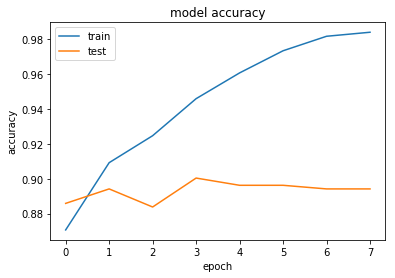

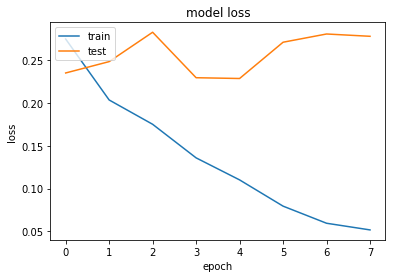

In [16]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
X_test=np.load('X_test.npy')
predicted_test=model.predict(X_test,verbose=1)

ValueError: cannot reshape array of size 48758760 into shape (8424,75,75,3)

In [ ]:
import pandas as pd
submission = pd.DataFrame()
test_id=np.load('test_id.npy')
submission['id']=test_id
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)